# EECE 7398: Verifiable Machine Learning -- Fall 2024
# Exercise #1: Adversarial Examples & Decision Boundaries

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.

# Problem 1: Train & Attack an MNIST Classifier

## 1a) Train an MNIST Classifier

To start, train a NN classifier that consists of:
- a "Flatten" layer to convert the (28, 28) images to (784,)
- a fully connected layer with 128 neurons and ReLU activation
- a fully connected (output) layer with 10 neurons (10 neurons for 10 digit categories)
- (optionally) a softmax layer to convert logits to probabilities

You can use the Adam optimizer with cross entropy loss (make sure to use the correct loss depending on whether you included a softmax layer) and it should work pretty well.

**Deliverables**:
- Plot your train and validation loss curves as a function of epoch
- From a test set, provide some examples where your classifier predicted correctly & incorrectly (if applicable)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

# Load the MNIST dataset
(train_imgs, train_lbls), (test_imgs, test_lbls) = mnist.load_data()

# Preprocess the images
train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0

# neural network model
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Train the model on the training data
history = model.fit(train_imgs, train_lbls, epochs=20, validation_split=0.2)



Epoch 1/20
1500/1500 [==============================] - 10s 5ms/step - loss: 0.2901 - accuracy: 0.9178 - val_loss: 0.1610 - val_accuracy: 0.9520
Epoch 2/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1281 - accuracy: 0.9625 - val_loss: 0.1184 - val_accuracy: 0.9651
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0881 - accuracy: 0.9740 - val_loss: 0.1076 - val_accuracy: 0.9682
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0674 - accuracy: 0.9796 - val_loss: 0.0998 - val_accuracy: 0.9718
Epoch 5/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0512 - accuracy: 0.9847 - val_loss: 0.0897 - val_accuracy: 0.9739
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0395 - accuracy: 0.9882 - val_loss: 0.0923 - val_accuracy: 0.9722
Epoch 7/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0318 - accuracy: 0.9901 - val_loss: 0.0895 - val_accuracy

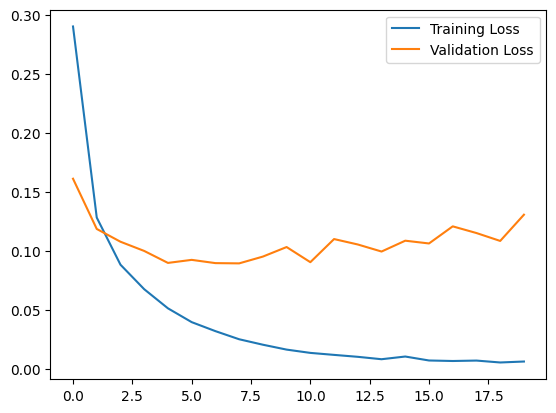

313/313 [==============================] - 1s 2ms/step


In [ ]:
# Plotting the loss curves for training and validation sets
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_imgs, test_lbls)


# Make predictions on the test set
y_pred = model.predict(test_imgs)

# Get the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Find correct and incorrect predictions

correct_pred_indices = np.where(y_pred_classes == test_lbls)[0]
incorrect_pred_indices = np.where(y_pred_classes != test_lbls)[0]

Correct predictions:


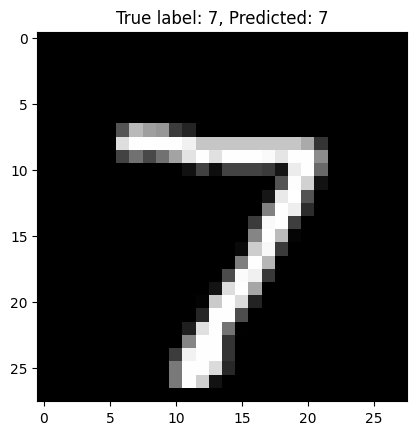

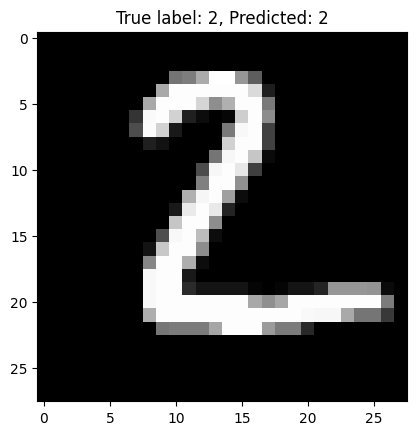

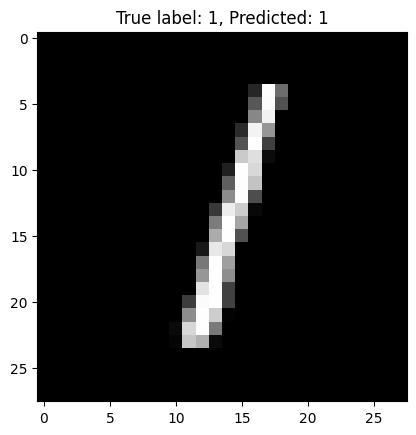

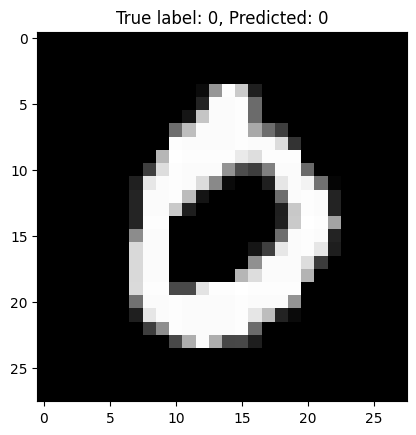

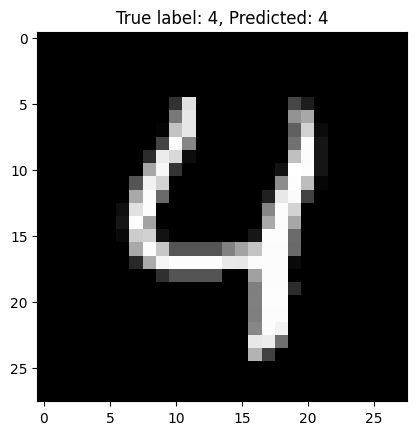

Incorrect predictions:


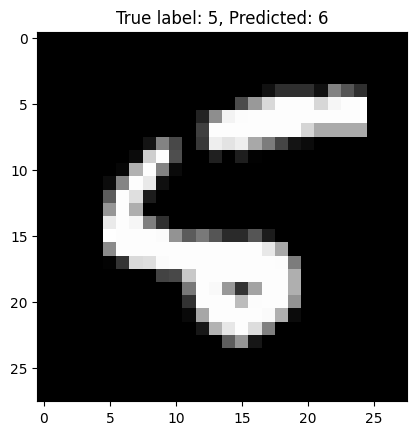

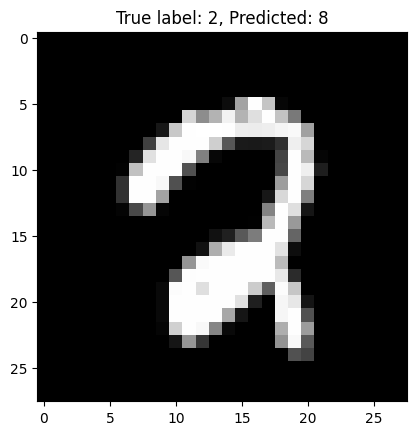

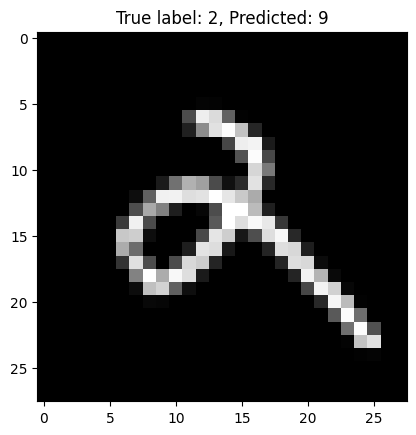

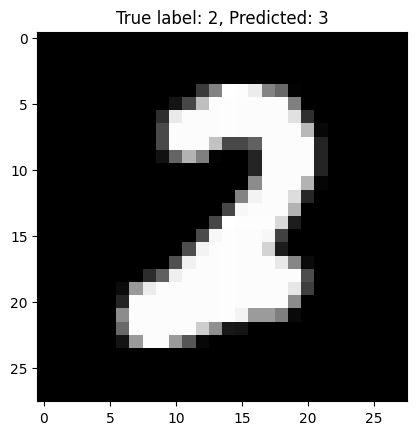

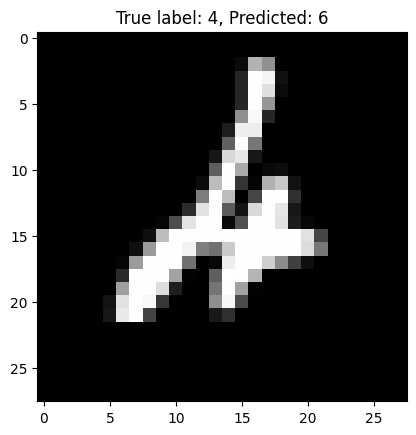

In [ ]:
#  correct predictions
print("Correct predictions:")
for i in range(5):
    plt.imshow(test_imgs[correct_pred_indices[i]], cmap='gray')
    plt.title(f"True label: {test_lbls[correct_pred_indices[i]]}, Predicted: {y_pred_classes[correct_pred_indices[i]]}")
    plt.show()

# Show some incorrect predictions
print("Incorrect predictions:")
for i in range(5):
    plt.imshow(test_imgs[incorrect_pred_indices[i]], cmap='gray')
    plt.title(f"True label: {test_lbls[incorrect_pred_indices[i]]}, Predicted: {y_pred_classes[incorrect_pred_indices[i]]}")
    plt.show()

## 1b) Attack your MNIST classifier with constant offsets

Add a constant perturbation to your test set images (e.g., c*torch.ones(28, 28)) and evaluate the performance as the magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- Provide some examples where the un-perturbed image was labeled correctly and the perturbed image was labeled incorrectly, despite the perturbed image looking reasonable to a human.

In [ ]:

#Function to add constant perturbations to images
def perturb_images(images, perturb_value):
    perturbed_images = images + perturb_value * np.ones_like(images)
    return np.clip(perturbed_images, 0, 1)  # Clip to keep pixel values in the valid range

# Evaluate the model's accuracy under different perturbation levels
perturbation_levels = np.linspace(0, 1, 10)
accuracies = []

for perturbation in perturbation_levels:
    # Apply the perturbation to the test images
    perturbed_test_images = perturb_images(test_imgs, perturbation)

    # Evaluate the model on the perturbed test images and store the accuracy
    test_loss, test_acc = model.evaluate(perturbed_test_images, test_lbls, verbose=0)
    accuracies.append(test_acc)




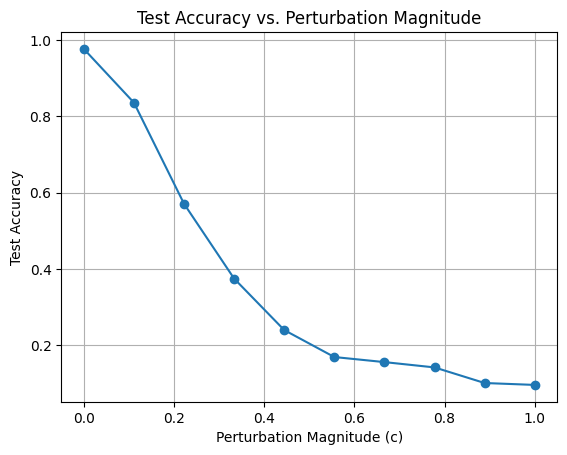

In [ ]:
#Plot the accuracy as a function of perturbation magnitude
plt.plot(perturbation_levels, accuracies, marker='o')
plt.xlabel('Perturbation Magnitude (c)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Perturbation Magnitude')
plt.grid(True)
plt.show()



313/313 [==============================] - 1s 2ms/step


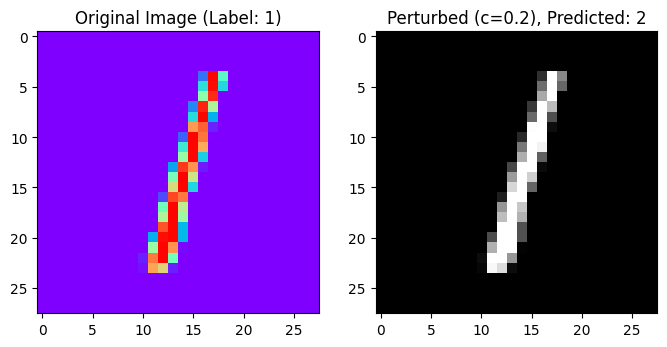

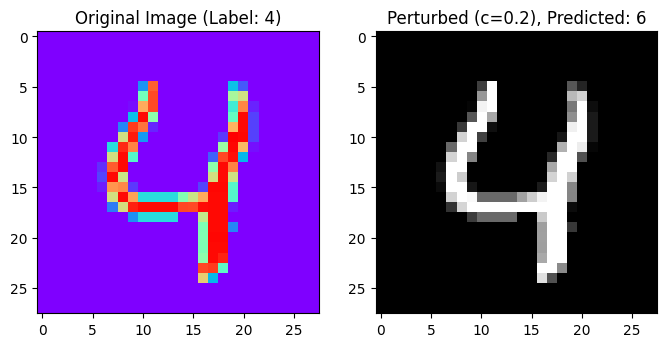

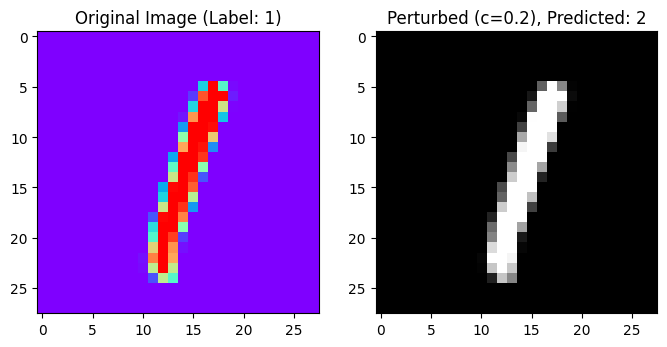

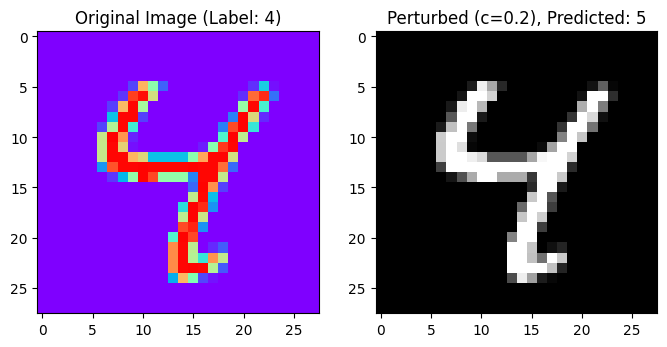

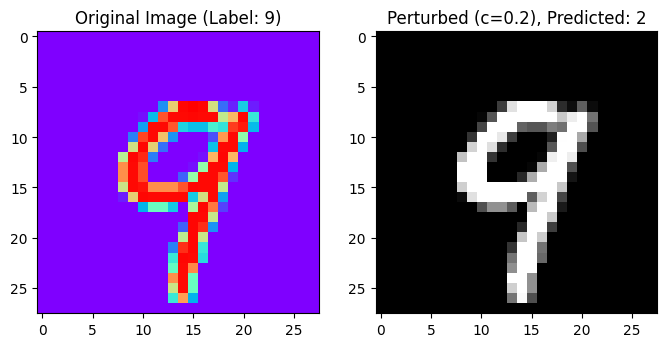

In [ ]:
# Identify examples where the original images were classified correctly
chosen_perturbation = 0.2
perturbed_images_example = perturb_images(test_imgs, chosen_perturbation)

# Get predictions for both original and perturbed test sets
original_predictions = model.predict(test_imgs)
perturbed_predictions = model.predict(perturbed_images_example)

# Find indices of correct predictions in the original data
correct_indices = np.where(np.argmax(original_predictions, axis=1) == test_lbls)[0]

# Find indices where the model misclassifies the perturbed data
misclassified_indices = np.where(np.argmax(perturbed_predictions, axis=1) != test_lbls)[0]

# Identify examples that were classified correctly before, but misclassified after perturbation
misclassified_after_perturbation = np.intersect1d(correct_indices, misclassified_indices)

# Display some examples of misclassification after perturbation
for idx in misclassified_after_perturbation[:5]:  # Show first 5 examples
    plt.figure(figsize=(8, 4))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(test_imgs[idx], cmap='rainbow')
    plt.title(f'Original Image (Label: {test_lbls[idx]})')

    # Display the perturbed image
    plt.subplot(1, 2, 2)
    plt.imshow(perturbed_images_example[idx], cmap='gray')
    plt.title(f'Perturbed (c={chosen_perturbation}), Predicted: {np.argmax(perturbed_predictions[idx])}')

    plt.show()

## 1c) Attack your MNIST classifier with noise

Add some noise perturbations to your test set images and evaluate the performance as the noise magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about any differences observed with constant perturbations vs. noise perturbations

313/313 [==============================] - 0s 2ms/step


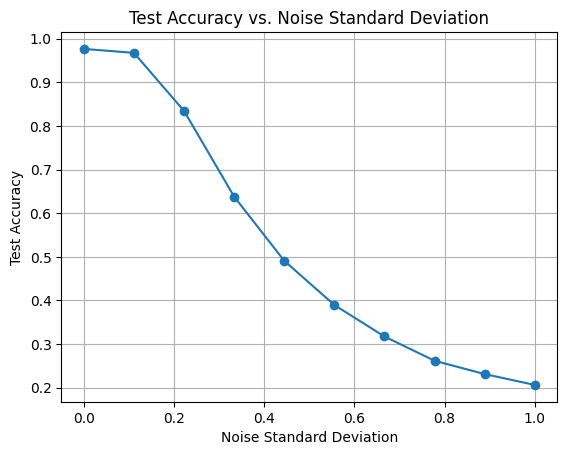

In [ ]:
#function to add Gaussian noise to the images
def apply_noise(imgs, noise_level):
    noisy_imgs = imgs + noise_level * np.random.normal(loc=0.0, scale=1.0, size=imgs.shape)
    return np.clip(noisy_imgs, 0, 1)  # Ensure pixel values remain between 0 and 1

# Evaluate the model on noisy test images for different noise levels
noise_magnitudes = np.linspace(0, 1, 10)
noisy_accuracies = []

for stddev in noise_magnitudes:
    noisy_test_images = apply_noise(test_imgs, stddev)
    noisy_predictions = model.predict(noisy_test_images)
    noisy_prediction_classes = np.argmax(noisy_predictions, axis=1)
    accuracy_score_noise = np.mean(noisy_prediction_classes == test_lbls)
    noisy_accuracies.append(accuracy_score_noise)

# Plot accuracy vs. noise standard deviation
plt.plot(noise_magnitudes, noisy_accuracies, marker='o')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Noise Standard Deviation')
plt.grid(True)
plt.show()

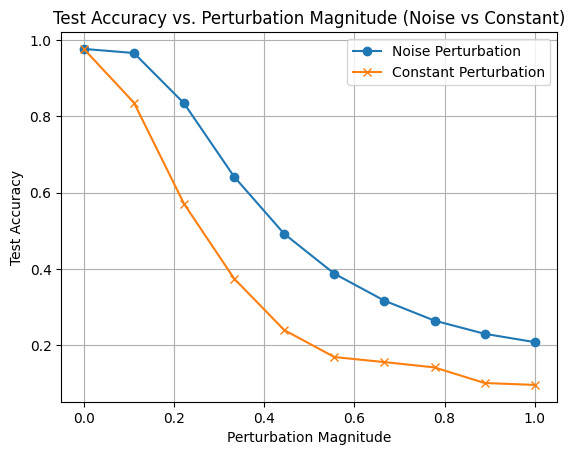

In [ ]:

#Plot the test accuracy as a function of noise magnitude
plt.plot(noise_magnitudes, noisy_accuracies, marker='o', label='Noise Perturbation')
plt.plot(perturbation_levels, accuracies, marker='x', label='Constant Perturbation')  # Using previous accuracies
plt.xlabel('Perturbation Magnitude')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Perturbation Magnitude (Noise vs Constant)')
plt.legend()
plt.grid(True)
plt.show()



Examples of noisy images with incorrect predictions:


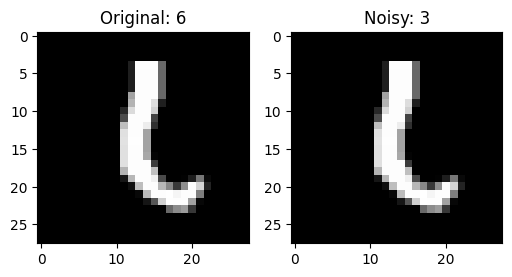

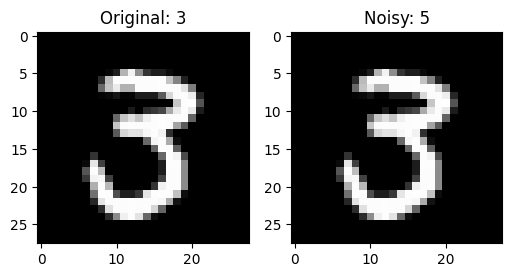

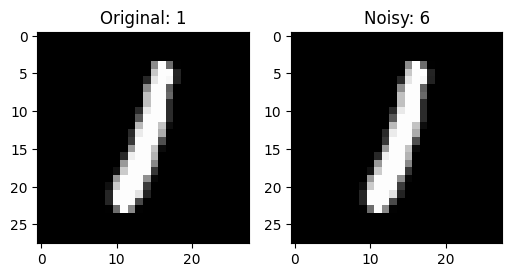

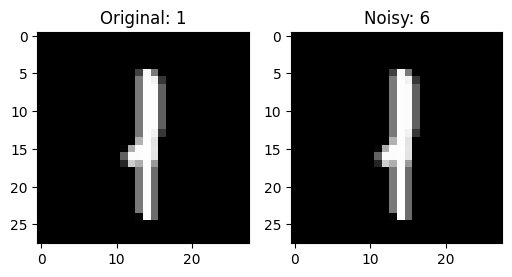

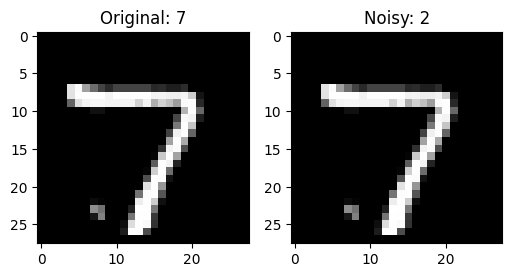

In [ ]:
# Find some examples of noisy images where the original was correct but noisy was incorrect
incorrect_noise_indices = np.where(noisy_prediction_classes != test_lbls)[0]
sampled_noise_indices = np.random.choice(incorrect_noise_indices, size=5, replace=False)

print("Examples of noisy images with incorrect predictions:")
for idx in sampled_noise_indices:
    plt.figure(figsize=(6, 3))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(test_imgs[idx].squeeze(), cmap='gray')
    plt.title(f"Original: {test_lbls[idx]}")

    # Noisy image
    noisy_image = apply_noise(test_imgs[idx:idx+1], noise_magnitudes[np.argmax(noisy_accuracies)])
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_image.squeeze(), cmap='gray')
    plt.title(f"Noisy: {noisy_prediction_classes[idx]}")

    plt.show()

In [ ]:
"""
Observation:
The model's performance deteriorates as both types of perturbations are introduced, but the effect of noise
is more pronounced. With constant perturbations, the decrease in accuracy is more gradual because the
perturbation is uniform across all pixels. In contrast, noise perturbations introduce random variations at
the pixel level, making it more challenging for the classifier to recognize digit patterns. As a result,
accuracy drops more sharply when random noise is applied, highlighting the model's sensitivity to
unpredictable distortions.
"""

## 1d) Attack your MNIST classifier with FGSM

Implement the Fast Gradient Sign Method (FGSM) attack algorithm and experiment with different values of $\epsilon$. You should write FGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements FGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about how this curve compares to the constant perturbations and noise perturbations (hopefully, FGSM should be able to achieve lower test accuracy for the same attack magnitude as those model-agnostic attacks)

In [ ]:


# FGSM attack function

def fgsm_attack(model, images, labels, epsilon):
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.int64)

    with tf.GradientTape() as tape:
        tape.watch(images_tensor)
        predictions = model(images_tensor, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels_tensor, predictions, from_logits=True)

    # Compute gradients
    gradients = tape.gradient(loss, images_tensor)
    sign_gradients = tf.sign(gradients)

   # Generate perturbed images
    perturbed_images = images_tensor + epsilon * sign_gradients
    perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)

    return perturbed_images.numpy()


In [ ]:
# Evaluate the model under different perturbation magnitudes
epsilon_values = np.linspace(0, 0.3, 10)  # Adjust range as needed
fgsm_accuracies = []

for epsilon in epsilon_values:
    perturbed_images = fgsm_attack(model, test_imgs, test_lbls, epsilon)
    test_loss, test_acc = model.evaluate(perturbed_images, test_lbls, verbose=0)
    fgsm_accuracies.append(test_acc)

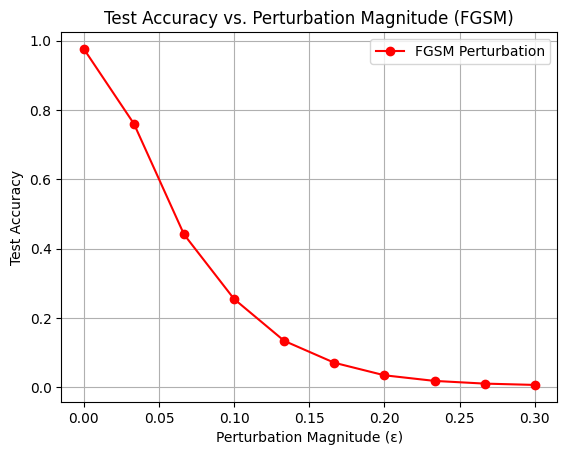

In [ ]:
# accuracy as a function of perturbation magnitude plot
plt.plot(epsilon_values, fgsm_accuracies, marker='o', color='red', label='FGSM Perturbation')
plt.xlabel('Perturbation Magnitude (ε)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Perturbation Magnitude (FGSM)')
plt.grid(True)
plt.legend()
plt.show()



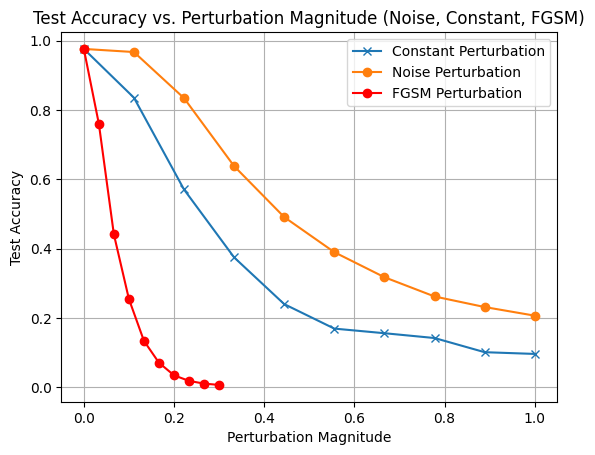

In [ ]:
plt.plot(perturbation_levels, accuracies, marker='x', label='Constant Perturbation')  # Assuming previous results
plt.plot(noise_magnitudes, noisy_accuracies, marker='o', label='Noise Perturbation')
plt.plot(epsilon_values, fgsm_accuracies, marker='o', color='red', label='FGSM Perturbation')
plt.xlabel('Perturbation Magnitude')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Perturbation Magnitude (Noise, Constant, FGSM)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

"""
Observations:
The FGSM attack leads to a more rapid decline in accuracy compared to constant and noise perturbations.
This is because FGSM is a model-targeted attack that uses the gradient of the loss function to create
perturbations designed specifically to fool the classifier. As a result, even small values of epsilon
can drastically reduce accuracy, especially compared to model-agnostic attacks like noise and constant
perturbations.
"""

## 1e) Attack your MNIST classifier with Targeted FGSM

Implement the Targeted Fast Gradient Sign Method (TFGSM) attack algorithm and experiment with different values of $\epsilon$. You should write TFGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements TFGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude for each target class
- A few example images where you were able to successfully cause the classifier to predict the targeted (incorrect) class
- A few sentences about your model's susceptibility to targeted attacks (e.g., are some target classes "easier" to get your model to classify? if you try to perturb images labeled 0 to a target class of 8, does the image get perturbed in an intuitive way?)

In [ ]:
#  TFGSM attack function
def tfgsm_attack(model, images, labels, target_class, epsilon):
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.int64)

    # Create a target class tensor
    target_tensor = tf.convert_to_tensor(np.full_like(labels, target_class), dtype=tf.int64)

    with tf.GradientTape() as tape:
        tape.watch(images_tensor)
        predictions = model(images_tensor, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(target_tensor, predictions, from_logits=True)

    gradients = tape.gradient(loss, images_tensor)
    sign_gradients = tf.sign(gradients)

    perturbed_images = images_tensor - epsilon * sign_gradients  # Minimize the loss for the target class
    perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)

    return perturbed_images.numpy()



In [ ]:

epsilon_values = np.linspace(0, 0.3, 10)
target_classes = list(range(10))  # Target each class from 0 to 9
tfgsm_accuracies = {target: [] for target in target_classes}

for target_class in target_classes:
    for epsilon in epsilon_values:
        perturbed_images = tfgsm_attack(model, test_imgs, test_lbls, target_class, epsilon)
        test_loss, test_acc = model.evaluate(perturbed_images, test_lbls, verbose=0)
        tfgsm_accuracies[target_class].append(test_acc)



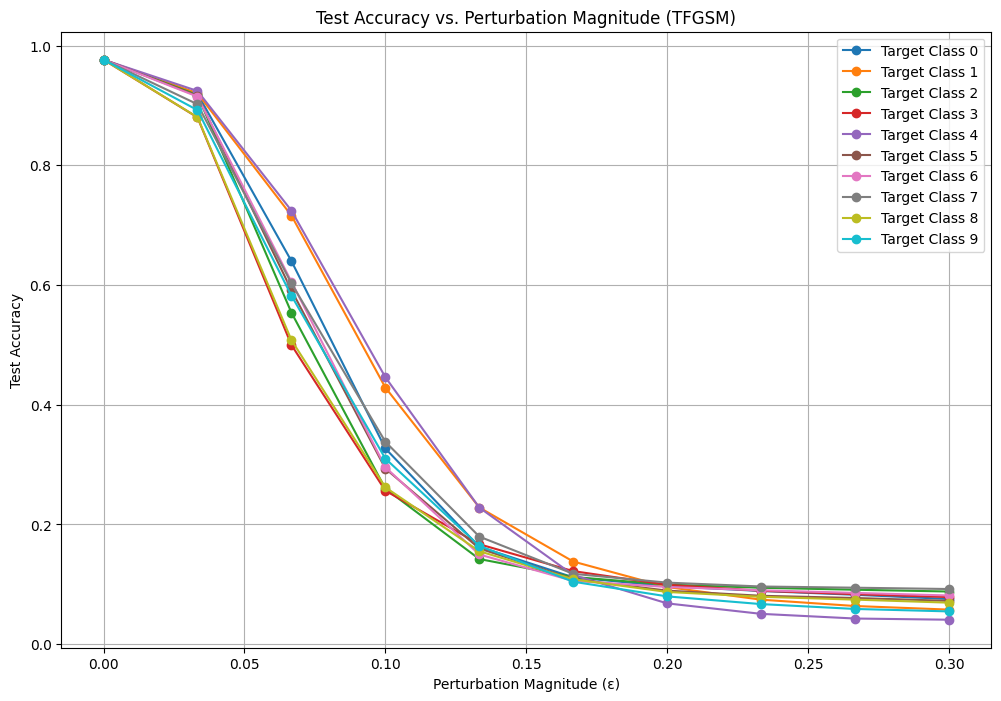

In [ ]:
# Plot the accuracy as a function of perturbation magnitude for each target class
plt.figure(figsize=(12, 8))
for target_class in target_classes:
    plt.plot(epsilon_values, tfgsm_accuracies[target_class], marker='o', label=f'Target Class {target_class}')

plt.xlabel('Perturbation Magnitude (ε)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Perturbation Magnitude (TFGSM)')
plt.grid(True)
plt.legend()  # Ensure this is called after all lines are plotted
plt.show()

313/313 [==============================] - 1s 2ms/step
Examples of successful attacks for target class 8:


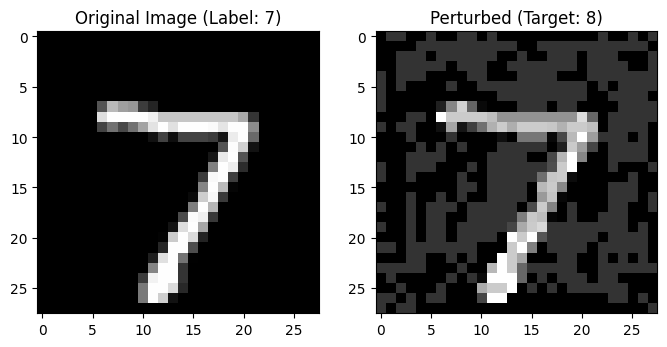

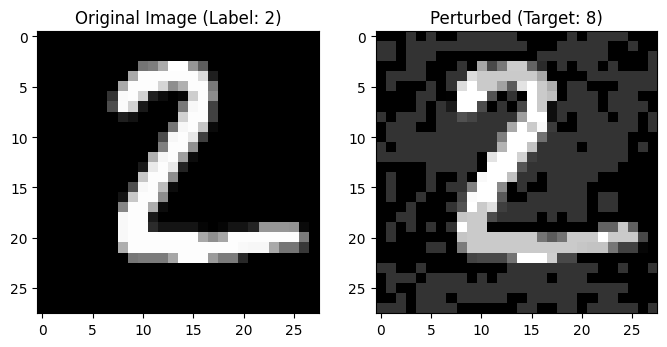

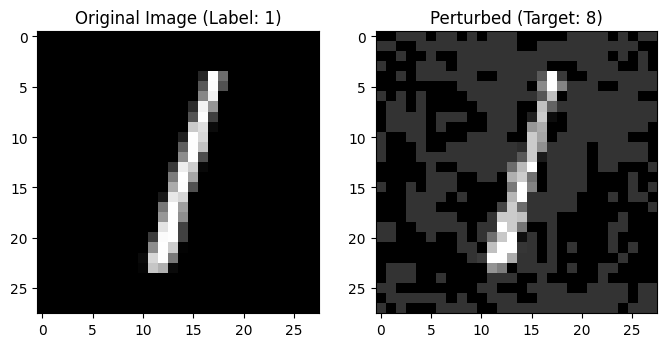

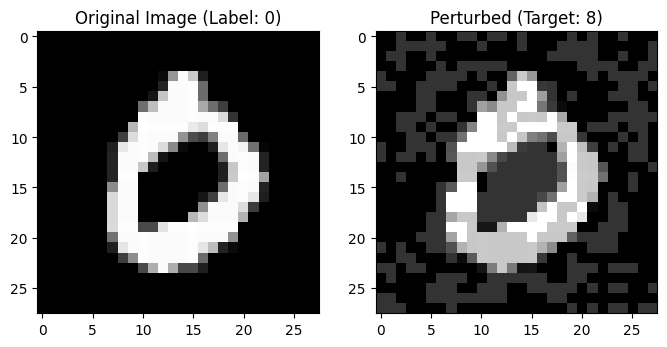

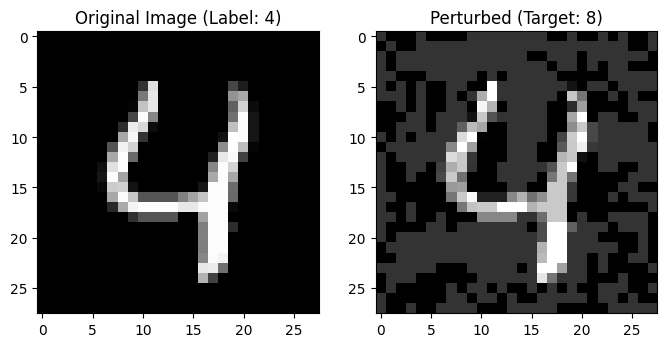

In [ ]:

# Examples of successful attacks
chosen_target_class = 8  # Example target class
epsilon = 0.2
perturbed_images = tfgsm_attack(model, test_imgs, test_lbls, chosen_target_class, epsilon)

# Eexamples where the attack was successful
correct_indices = np.where(np.argmax(model.predict(test_imgs), axis=1) == test_lbls)[0]
successful_attack_indices = np.where(np.argmax(model.predict(perturbed_images), axis=1) == chosen_target_class)[0]

print(f"Examples of successful attacks for target class {chosen_target_class}:")
for idx in successful_attack_indices[:5]:  # Show first 5 examples
    plt.figure(figsize=(8, 4))

    #  original image
    plt.subplot(1, 2, 1)
    plt.imshow(test_imgs[idx], cmap='gray')
    plt.title(f'Original Image (Label: {test_lbls[idx]})')

    #  perturbed image
    plt.subplot(1, 2, 2)
    plt.imshow(perturbed_images[idx], cmap='gray')
    plt.title(f'Perturbed (Target: {chosen_target_class})')

    plt.show()

In [ ]:
"""
Observation:
The targeted FGSM attack shows that as the perturbation magnitude increases, the model's accuracy drops sharply, especially for the targeted class.
Some target classes may be easier to fool than others, depending on their similarity to the original class.
For instance, perturbing images labeled '0' to be classified as '8' might result in more noticeable changes compared to perturbing '0' to '1'.
The model's susceptibility to targeted attacks can reveal vulnerabilities in class boundaries and indicate areas for improvement in model robustness.
"""

# Problem 2: Investigating Decision Boundaries

In this problem, you will train a binary classifier for a 2D input vector (is the (x, y) coordinate inside a circle of radius r centered at the origin?).

Since you will know the true decision boundary that the model is trained to approximate, you can generate training data.

Then, you will investigate the model's decision boundary to see how well it matches the true decision boundary.

## 2a) Generate training data

For $x\in R^2$, using the decision rule $f(x) = \begin{cases} 1, &\lvert\lvert x \rvert\rvert_2 \leq 3 \\ 0, & \text{o.w.} \end{cases}$, generate a training, validation, and test set of $[x, f(x)]$ pairs.

**Deliverables:**
- Plot your training set and the true decision boundary

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Generaing random points using a Gaussian distribution
np.random.seed(42)
num_points = 5000
mean = [0, 0]
cov = [[5, 0], [0, 5]]
x_data = np.random.multivariate_normal(mean, cov, num_points)

# Decision rule 1 - if point is inside the circle of radius 3, else 0
def decision_boundary(point):
    return 1 if np.linalg.norm(point) <= 3 else 0

# applying decision rule to all points
y_data = np.array([decision_boundary(p) for p in x_data])

# Splitting data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

#training set and true decision boundary plot
theta = np.linspace(0, 2 * np.pi, 100)
circle_x = 3 * np.cos(theta)
circle_y = 3 * np.sin(theta)





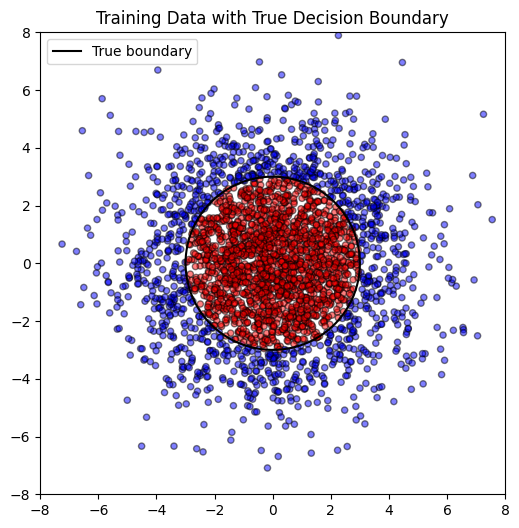

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='bwr', alpha=0.5, edgecolor='k', s=20)
plt.plot(circle_x, circle_y, color='black', label='True boundary')
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.title('Training Data with True Decision Boundary')
plt.legend()
plt.show()


## 2b) Train NN classifier

Train a NN classifier on the data you just generated.

**Deliverables**:
- Plot your train & validation loss curves as a function of epoch

In [ ]:
# neural network model
model = models.Sequential([
    layers.Dense(64, input_dim=2),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.3),

    layers.Dense(128),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.3),

    layers.Dense(64),
    layers.LeakyReLU(alpha=0.1),

    layers.Dense(1, activation='sigmoid')
])





In [ ]:
# Compiling the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# avoiding overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_val, y_val), callbacks=[early_stopping])



Epoch 1/100
47/47 [==============================] - 3s 10ms/step - loss: 0.6064 - accuracy: 0.6623 - val_loss: 0.5057 - val_accuracy: 0.9070
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 0.4317 - accuracy: 0.8420 - val_loss: 0.2824 - val_accuracy: 0.9630
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 0.2687 - accuracy: 0.8973 - val_loss: 0.1676 - val_accuracy: 0.9730
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: 0.1984 - accuracy: 0.9197 - val_loss: 0.1407 - val_accuracy: 0.9590
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 0.1759 - accuracy: 0.9253 - val_loss: 0.1111 - val_accuracy: 0.9670
Epoch 6/100
47/47 [==============================] - 0s 5ms/step - loss: 0.1683 - accuracy: 0.9247 - val_loss: 0.1614 - val_accuracy: 0.9160
Epoch 7/100
47/47 [==============================] - 0s 7ms/step - loss: 0.1483 - accuracy: 0.9343 - val_loss: 0.1391 - val_accuracy: 0.9330
Epoch 8/100


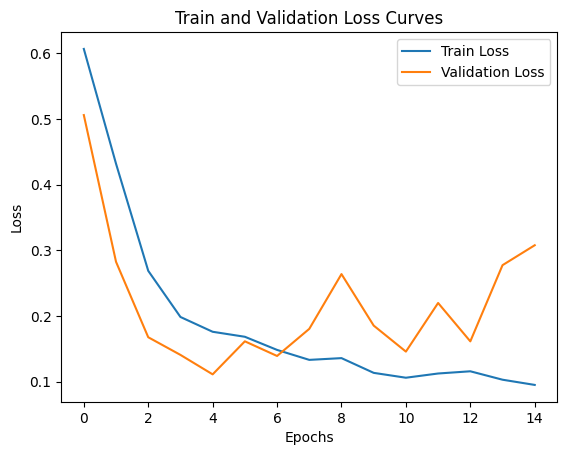

In [ ]:
# Plot the train and validation loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2c) Compare decision boundaries

It is unlikely that your model has learned the true decision boundary perfectly. Here, you will investigate the differences.

**Deliverables**:
- Plot the true and learned decision boundaries
- A few sentences (with relevant figures to illustrate observations) about any differences and how changes to the model architecture or training procedure can impact decision boundaries (e.g., adding regularization, changing the training data generation method, changing the activation functions).

In [ ]:
# grid of points for decision boundary comparison
grid_x, grid_y = np.meshgrid(np.linspace(-8, 8, 300), np.linspace(-8, 8, 300))
grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]

# Predict class probabilities for each point in the grid
grid_preds = model.predict(grid_points)
grid_preds = grid_preds.reshape(grid_x.shape)




2813/2813 [==============================] - 6s 2ms/step


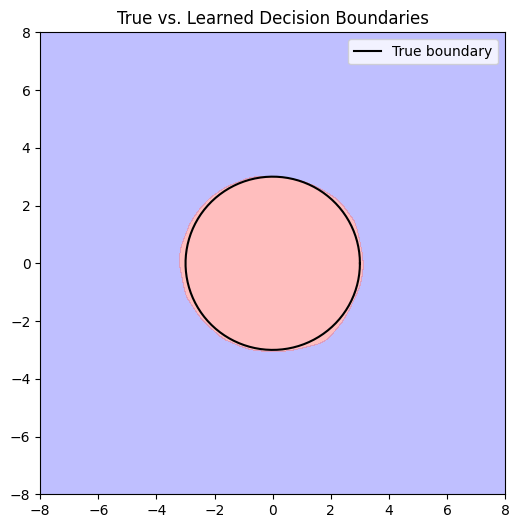

In [ ]:
# Plot the true boundary and learned decision boundary
plt.figure(figsize=(6, 6))
plt.contourf(grid_x, grid_y, grid_preds, levels=[0, 0.5, 1], cmap='bwr', alpha=0.5)
plt.plot(circle_x, circle_y, color='black', label='True boundary')
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.legend()
plt.title('True vs. Learned Decision Boundaries')
plt.show()


In [ ]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

32/32 [==============================] - 0s 2ms/step - loss: 0.1099 - accuracy: 0.9690
Test Accuracy: 96.90%


# Problem 3: Attack Competition on a Pre-Trained CIFAR-10 Classifier [Extra Credit]

## 3.1 White-Box $l_\infty$-norm Attack

Here, you will have access to the full model (i.e., you know all of its parameters and architecture, you can compute gradients). You should write a function that takes in:
- the model
- a set of images + corresponding labels
- a perturbation magnitude,

and returns a perturbed version of the provided images that will cause the model to have poor classification accuracy.

We provide a template for your attack function and a function for checking the classification accuracy so that you can prototype locally. Once you upload your .ipynb to Gradescope (make sure it is named `hw1.ipynb`), we will run your attack function against some random test images and maintain a leaderboard of the strongest attack (we provide the actual evaluation script below for your convenience). Every student that gets the accuracy below 40% will get some extra credit, and the student with strongest attack will get more extra credit. In case of a tie, we will look at runtime. You can keep updating your submission until the deadline.

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
import time



```
# This is formatted as code
```

Here's a suggested way of getting the CIFAR-10 dataset:

In [54]:
device = 'cuda'
batch_size = 256

transform = transforms.Compose([transforms.ToTensor()])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Here's the model you'll be attacking (ResNet20):

In [44]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


While CIFAR-10 images have pixel values $\in [0, 1]$, the model we're attacking was trained on a normalized version of CIFAR-10 (i.e., each image was shifted/scaled by a mean/std). You can attack the model in the original pixel coordinates (that's the space we'll enforce the attack magnitude), but remember that any time you want to query the model, you should first normalize the images according to those settings:

In [45]:
def normalize(imgs):
  mean = (0.4914, 0.4822, 0.4465)
  std = (0.2023, 0.1994, 0.2010)
  Normalize = transforms.Normalize(mean=mean, std=std)
  return Normalize(imgs)

This function may help you when familiarizing yourself with the dataset and baseline model performance (and shows an example of using the normalize function right before querying the model):

In [46]:
def quickly_run_model(model, testloader, num_to_show=4):
  dataiter = iter(testloader)

  # images coming out of the dataloader are tensors of size (batch, 3, 32, 32)
  # where each pixel is within [0, 1].
  images, labels = next(dataiter)

  model = model.to(device)
  images = images.to(device)
  labels = labels.to(device)

  # The model was trained on a normalized version of the dataset
  # (i.e., each pixel was scaled/shifted by mean and std).
  # ==> we will normalize our images in that same way before querying model
  normalized_images = normalize(images)
  outputs = model(normalized_images)
  _, predicted = torch.max(outputs, 1)
  print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(num_to_show)))
  print('Labels: ', ' '.join(f'{classes[labels[j]]:5s}'
                                for j in range(num_to_show)))

quickly_run_model(model, testloader)

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e74b61e8550><function _MultiProcessingDataLoaderIter.__del__ at 0x7e74b61e8550>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    self._shutdown_workers()    
if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

Predicted:  cat   ship  ship  plane
Labels:  cat   ship  ship  plane


The function you will fill in is `white_box_attack`. The autograder expects this exact function name and signature, so make sure those stay the same:

In [55]:
import torch
import torch.nn.functional as F

def white_box_attack(model, raw_images, labels, attack_magnitude):
    raw_images.requires_grad = True
    model.eval()

    normalized_images = normalize(raw_images)
    outputs = model(normalized_images)

    loss = F.cross_entropy(outputs, labels)

    model.zero_grad()
    loss.backward()
    image_gradients = raw_images.grad.data
    perturbed_images = raw_images + attack_magnitude * image_gradients.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)

    return perturbed_images

To help you debug, here's the function we will use to evaluate your `white_box_attack`. This should give 92.6% accuracy when there is no attack. This function is meant to be able to run standalone (i.e., not in a Jupyter notebook where the model/dataset may already be loaded), so feel free to modify it to be more efficient when debugging. We will run your attack against our own replica of this function on Gradescope's servers, so the runtime numbers will likely differ from what you observe locally or on Colab:

In [48]:
def evaluate_attacked_accuracy(attack_magnitude, attack_fn=white_box_attack, device='cpu'):

  # We will run your attack against this function to establish the leaderboard

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          pin_memory=True)

  model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

  attack_runtime = 0.
  correct = 0
  total = 0
  model.to(device)
  model.eval()
  for raw_images, labels in testloader:

    raw_images = raw_images.to(device)
    labels = labels.to(device)

    attack_runtime_start = time.time()
    normalized_raw_images = normalize(raw_images)
    perturbed_images = attack_fn(model, raw_images, labels, attack_magnitude)
    attack_runtime_end = time.time()
    attack_runtime += attack_runtime_end - attack_runtime_start

    assert torch.all(perturbed_images <= 1.) and torch.all(perturbed_images >= 0.), "Perturbed images contain pixels outside of [0, 1]."
    assert torch.all(torch.linalg.vector_norm(perturbed_images - raw_images, ord=torch.inf, dim=(1,2,3)) <= attack_magnitude + 1e-6), "Perturbation violates attack magnitude limit."

    # calculate outputs by running images through the network
    with torch.no_grad():
      normalized_perturbed_images = normalize(perturbed_images)
      outputs = model(normalized_perturbed_images)

    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total

  return accuracy, attack_runtime

You can run the above evaluation function as follows:

In [53]:
attack_magnitude = 1 / 255
accuracy, attack_runtime = evaluate_attacked_accuracy(attack_magnitude)
print(f"Accuracy: {accuracy}%")
print(f"Attack Runtime: {attack_runtime} seconds")

Files already downloaded and verified


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Accuracy: 44.49%
Attack Runtime: 82.91658616065979 seconds
